In [84]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data/nhanes32006data.csv')

In [3]:
data.head()

,Unnamed: 0,age,agestrat,sex,race,ses,smokehx,bmi,obese,htnhx,...,higlu,hba1c,dm,hf,stroke,mi,fasttime,fast,mortstat,PERMTH_INT
0,1,21.750000,21-35,male,non hispanic black,0.641,yes,25.5,no,hypertensive,...,no,5.3,no,no,no,no,6.52,no,alive,203.0
1,2,32.000000,21-35,female,non hispanic black,4.803,yes,23.4,yes,no,...,no,4.6,no,no,no,no,6.12,no,alive,201.0
2,3,48.583333,35-50,female,hispanic,3.747,no,27.6,yes,no,...,no,5.3,no,no,no,no,13.73,no,alive,201.0
3,4,35.666667,35-50,male,hispanic,5.406,yes,29.4,yes,hypertensive,...,no,4.6,no,no,no,no,15.45,no,alive,196.0
4,5,48.500000,35-50,male,non hispanic black,1.676,no,25.0,no,no,...,yes,9.1,diabetes,no,no,no,1.85,yes,alive,190.0


In [4]:
data.shape

(18414, 33)

In [5]:
required_columns = ['obese', 'uralb', 'trig', 'hdl', 'chol', 'hldhx', 'htnhx', 'sbp', 'dbp', 'bmi', 'smokehx', 'ses', 'race', 'sex', 'age', 'hf', 'stroke', 'mi', 'hba1c']
target = "mortstat"

In [6]:
data[required_columns].dtypes

obese       object
uralb      float64
trig       float64
hdl        float64
chol       float64
hldhx      float64
htnhx       object
sbp        float64
dbp        float64
bmi        float64
smokehx     object
ses        float64
race        object
sex         object
age        float64
hf          object
stroke      object
mi          object
hba1c      float64
dtype: object

In [7]:
data = data[required_columns + [target]]

In [8]:
data.head()

,obese,uralb,trig,hdl,chol,hldhx,htnhx,sbp,dbp,bmi,smokehx,ses,race,sex,age,hf,stroke,mi,hba1c,mortstat
0,no,5.8,174.0,38.0,268.0,1.0,hypertensive,120.0,67.0,25.5,yes,0.641,non hispanic black,male,21.750000,no,no,no,5.3,alive
1,yes,2.2,84.0,55.0,160.0,1.0,no,126.0,86.0,23.4,yes,4.803,non hispanic black,female,32.000000,no,no,no,4.6,alive
2,yes,1.6,98.0,66.0,236.0,2.0,no,131.0,73.0,27.6,no,3.747,hispanic,female,48.583333,no,no,no,5.3,alive
3,yes,8.5,109.0,43.0,225.0,2.0,hypertensive,130.0,82.0,29.4,yes,5.406,hispanic,male,35.666667,no,no,no,4.6,alive
4,no,11.3,94.0,51.0,260.0,1.0,no,120.0,70.0,25.0,no,1.676,non hispanic black,male,48.500000,no,no,no,9.1,alive


In [9]:
data.shape

(18414, 20)

In [10]:
data = data[(data['age'] >= 45 ) & (data['age'] <= 65)]

In [11]:
data.shape

(4545, 20)

Read the number of nan values

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4545 entries, 2 to 18407
Data columns (total 20 columns):
obese       4115 non-null object
uralb       4115 non-null float64
trig        3974 non-null float64
hdl         3949 non-null float64
chol        3980 non-null float64
hldhx       4418 non-null float64
htnhx       4525 non-null object
sbp         4108 non-null float64
dbp         4107 non-null float64
bmi         4141 non-null float64
smokehx     4545 non-null object
ses         4545 non-null float64
race        4545 non-null object
sex         4545 non-null object
age         4545 non-null float64
hf          4541 non-null object
stroke      4543 non-null object
mi          4484 non-null object
hba1c       4022 non-null float64
mortstat    4541 non-null object
dtypes: float64(11), object(9)
memory usage: 745.7+ KB


Percentage of missing data

In [13]:
data.isna().any(axis = 1).sum()

821

In [14]:
100*821/data.shape[0]

18.063806380638063

In [15]:
data['hldhx'] = data['hldhx'].astype(object)

In [16]:
categorical_columns = data.select_dtypes('object').columns
categorical_columns

Index(['obese', 'hldhx', 'htnhx', 'smokehx', 'race', 'sex', 'hf', 'stroke',
       'mi', 'mortstat'],
      dtype='object')

In [17]:
numerical_columns = list(set(data.columns) - set(categorical_columns))
numerical_columns

['ses', 'hdl', 'sbp', 'bmi', 'trig', 'chol', 'age', 'hba1c', 'uralb', 'dbp']

Missing data in Categorical Columns

In [18]:
def count_empty(data, columns):
    return data[columns].isna().sum()

Percentage of missing data in each column

In [19]:
def percentage_empty(data, columns):
    return 100*data[columns].isna().sum()/data.shape[0]

In [20]:
percentage_empty(data, categorical_columns)

obese       9.460946
hldhx       2.794279
htnhx       0.440044
smokehx     0.000000
race        0.000000
sex         0.000000
hf          0.088009
stroke      0.044004
mi          1.342134
mortstat    0.088009
dtype: float64

In [21]:
data.loc[data['obese'].isnull(), 'obese'] = "Not_Available"
data.loc[data['htnhx'].isnull(), 'htnhx'] = "Not_Available"
data.loc[data['mi'].isnull(), 'mi'] = "Not_Available"

In [22]:
percentage_empty(data, categorical_columns)

obese       0.000000
hldhx       2.794279
htnhx       0.000000
smokehx     0.000000
race        0.000000
sex         0.000000
hf          0.088009
stroke      0.044004
mi          0.000000
mortstat    0.088009
dtype: float64

In [23]:
count_empty(data, categorical_columns)

obese         0
hldhx       127
htnhx         0
smokehx       0
race          0
sex           0
hf            4
stroke        2
mi            0
mortstat      4
dtype: int64

In [24]:
data['hf'].value_counts(dropna = False)

no     4344
yes     197
NaN       4
Name: hf, dtype: int64

In [25]:
data['stroke'].value_counts(dropna = False)

no     4423
yes     120
NaN       2
Name: stroke, dtype: int64

In [26]:
data.loc[data['hf'].isna(), 'hf'] = 'no'
data.loc[data['stroke'].isna(), 'stroke'] = 'no'

In [27]:
data.dropna(subset=['mortstat'], inplace=True)

In [28]:
data.shape

(4541, 20)

In [29]:
count_empty(data, categorical_columns)

obese         0
hldhx       126
htnhx         0
smokehx       0
race          0
sex           0
hf            0
stroke        0
mi            0
mortstat      0
dtype: int64

Missing values in Numeric columns

In [30]:
data[numerical_columns].head()

,ses,hdl,sbp,bmi,trig,chol,age,hba1c,uralb,dbp
2,3.747,66.0,131.0,27.6,98.0,236.0,48.583333,5.3,1.6,73.0
4,1.676,51.0,120.0,25.0,94.0,260.0,48.500000,9.1,11.3,70.0
9,5.690,42.0,128.0,37.0,171.0,156.0,56.750000,5.0,0.4,73.0
12,3.416,47.0,117.0,25.1,204.0,244.0,50.166667,5.9,1.8,74.0
14,0.622,30.0,155.0,37.5,479.0,212.0,48.416667,5.7,105.0,91.0


In [31]:
count_empty(data, numerical_columns)

ses        0
hdl      594
sbp      435
bmi      402
trig     569
chol     563
age        0
hba1c    521
uralb    428
dbp      436
dtype: int64

In [32]:
data[numerical_columns].describe()

,ses,hdl,sbp,bmi,trig,chol,age,hba1c,uralb,dbp
count,4541.000000,3947.000000,4106.000000,4139.000000,3972.000000,3978.000000,4541.000000,4020.000000,4113.000000,4105.000000
mean,90829.226700,50.940208,130.559425,28.259169,168.083082,220.635244,55.274829,5.856741,16481.607464,78.114007
std,269259.686231,16.529811,18.245931,5.752427,140.306292,44.678731,6.021957,1.371941,119715.813978,9.881913
min,0.000000,12.000000,81.000000,13.300000,22.000000,59.000000,45.000000,3.300000,0.400000,43.000000
25%,1.345000,40.000000,118.000000,24.299999,93.000000,191.000000,50.000000,5.200000,2.700000,71.000000
50%,2.701000,48.000000,128.000000,27.400000,133.000000,218.000000,55.333333,5.500000,6.800000,77.000000
75%,4.810000,59.000000,141.000000,31.299999,197.000000,246.000000,60.833333,6.000000,16.200000,84.000000
max,888888.000000,191.000000,237.000000,67.300003,3616.000000,702.000000,65.000000,16.200001,888888.000000,134.000000


In [33]:
data.loc[data['uralb'] == 888888.000, 'uralb'] = np.nan
data.loc[data['ses'] == 888888.000, 'ses'] = np.nan

In [34]:
data[numerical_columns].describe()

,ses,hdl,sbp,bmi,trig,chol,age,hba1c,uralb,dbp
count,4077.000000,3947.000000,4106.000000,4139.000000,3972.000000,3978.000000,4541.000000,4020.000000,4037.000000,4105.000000
mean,2.817377,50.940208,130.559425,28.259169,168.083082,220.635244,55.274829,5.856741,57.806168,78.114007
std,1.967585,16.529811,18.245931,5.752427,140.306292,44.678731,6.021957,1.371941,406.745718,9.881913
min,0.000000,12.000000,81.000000,13.300000,22.000000,59.000000,45.000000,3.300000,0.400000,43.000000
25%,1.215000,40.000000,118.000000,24.299999,93.000000,191.000000,50.000000,5.200000,2.700000,71.000000
50%,2.383000,48.000000,128.000000,27.400000,133.000000,218.000000,55.333333,5.500000,6.600000,77.000000
75%,4.020000,59.000000,141.000000,31.299999,197.000000,246.000000,60.833333,6.000000,15.000000,84.000000
max,11.290000,191.000000,237.000000,67.300003,3616.000000,702.000000,65.000000,16.200001,12400.000000,134.000000


Data shows outliers in trig and uralb

In [35]:
np.nanpercentile(data['trig'], 99)

717.5799999999999

In [36]:
np.nanpercentile(data['uralb'], 99.5)

2700.0

In [37]:
data.loc[data['trig'] > np.nanpercentile(data['trig'], 99), 'trig'] = np.nanpercentile(data['trig'], 99)

In [38]:
data.loc[data['uralb'] > np.nanpercentile(data['uralb'], 99.5), 'uralb'] = np.nanpercentile(data['uralb'], 99.5)

In [39]:
data.describe()

,uralb,trig,hdl,chol,sbp,dbp,bmi,ses,age,hba1c
count,4037.000000,3972.000000,3947.000000,3978.000000,4106.000000,4105.000000,4139.000000,4077.000000,4541.000000,4020.000000
mean,46.896086,165.133736,50.940208,220.635244,130.559425,78.114007,28.259169,2.817377,55.274829,5.856741
std,243.498289,114.508905,16.529811,44.678731,18.245931,9.881913,5.752427,1.967585,6.021957,1.371941
min,0.400000,22.000000,12.000000,59.000000,81.000000,43.000000,13.300000,0.000000,45.000000,3.300000
25%,2.700000,93.000000,40.000000,191.000000,118.000000,71.000000,24.299999,1.215000,50.000000,5.200000
50%,6.600000,133.000000,48.000000,218.000000,128.000000,77.000000,27.400000,2.383000,55.333333,5.500000
75%,15.000000,197.000000,59.000000,246.000000,141.000000,84.000000,31.299999,4.020000,60.833333,6.000000
max,2700.000000,717.580000,191.000000,702.000000,237.000000,134.000000,67.300003,11.290000,65.000000,16.200001


In [40]:
for column in numerical_columns:
    data.loc[data[column].isna(), column] = data[column].mean()

In [41]:
count_empty(data, numerical_columns)

ses      0
hdl      0
sbp      0
bmi      0
trig     0
chol     0
age      0
hba1c    0
uralb    0
dbp      0
dtype: int64

In [42]:
data.columns

Index(['obese', 'uralb', 'trig', 'hdl', 'chol', 'hldhx', 'htnhx', 'sbp', 'dbp',
       'bmi', 'smokehx', 'ses', 'race', 'sex', 'age', 'hf', 'stroke', 'mi',
       'hba1c', 'mortstat'],
      dtype='object')

In [43]:
data['mortstat'].value_counts()

alive    3494
dead     1047
Name: mortstat, dtype: int64

Removing Bivariate

In [44]:
data['mortstat'] = data['mortstat'].map({
    'alive' : 0,
    'dead' : 1
})

In [45]:
data['mortstat'].value_counts(normalize = True)

0    0.769434
1    0.230566
Name: mortstat, dtype: float64

In [46]:
categorical_columns = list(categorical_columns)
categorical_columns.remove('mortstat')

In [47]:
er_data = pd.DataFrame()
for column in categorical_columns:
    groupby_data = data[[column] + ['mortstat']].groupby(column).agg({'mortstat' : ['sum', 'count']})
    groupby_data.columns = ['deaths', 'population']
    groupby_data.reset_index(inplace=True)
    groupby_data['event_rate'] = 100*groupby_data['deaths']/groupby_data['population']
    groupby_data['population_dist'] = 100*groupby_data['population']/ groupby_data['population'].sum()
    groupby_data.columns = ['levels', 'deaths', 'population', 'death_rate', 'population_dist']
    groupby_data['field'] = column
    er_data = er_data.append(groupby_data)
er_data = er_data[['field', 'levels', 'deaths', 'population', 'death_rate', 'population_dist']]

In [48]:
er_data

,field,levels,deaths,population,death_rate,population_dist
0,obese,Not_Available,132,428,30.841121,9.425237
1,obese,no,369,1778,20.753656,39.154371
2,obese,yes,546,2335,23.383298,51.420392
0,hldhx,1,375,1530,24.509804,34.654587
1,hldhx,2,625,2885,21.663778,65.345413
0,htnhx,Not_Available,4,20,20.000000,0.440432
1,htnhx,hypertensive,522,1689,30.905861,37.194451
2,htnhx,no,521,2832,18.396893,62.365118
0,smokehx,no,784,2743,28.581845,60.405197
1,smokehx,yes,263,1798,14.627364,39.594803


Ploting death rates

In [49]:
def plt_event_rate(er_data):
    for field in er_data['field'].unique():
        trace1 = go.Bar(x=list(er_data[er_data['field'] == field]['levels'].values), y=list(er_data[er_data['field'] == field]['population_dist'].values))
        trace2 = go.Scatter(x=list(er_data[er_data['field'] == field]['levels'].values), y=list(er_data[er_data['field'] == field]['death_rate'].values), yaxis='y2')
        data = [trace1, trace2]
        layout = go.Layout(
            title="Double Y axis - "+field.capitalize(),
            yaxis=dict(
                title='Population Distibution'
            ),
            yaxis2=dict(
                title='Death Rate',
                titlefont=dict(
                    color='rgb(148, 103, 189)'
                ),
                tickfont=dict(
                    color='rgb(148, 103, 189)'
                ),
                overlaying='y',
                side='right'
            )
        )
        fig = go.Figure(data=data, layout=layout)
        plot_url = iplot(fig, filename='multiple-axes-double')

In [50]:
plt_event_rate(er_data)

In [51]:
er_data = pd.DataFrame()
for column in numerical_columns:
    data['decile'] = pd.qcut(data[column], q=10, duplicates='drop', labels=False)
    groupby_data = data[['decile'] + ['mortstat']].groupby('decile').agg({'mortstat' : ['sum', 'count']})
    groupby_data.columns = ['deaths', 'population']
    groupby_data.reset_index(inplace=True)
    groupby_data['event_rate'] = 100*groupby_data['deaths']/groupby_data['population']
    groupby_data['population_dist'] = 100*groupby_data['population']/ groupby_data['population'].sum()
    groupby_data.columns = ['levels', 'deaths', 'population', 'death_rate', 'population_dist']
    groupby_data['field'] = column
    er_data = er_data.append(groupby_data)

In [52]:
er_data

,levels,deaths,population,death_rate,population_dist,field
0,0,146,455,32.087912,10.019819,ses
1,1,180,458,39.301310,10.085884,ses
2,2,117,451,25.942350,9.931733,ses
3,3,105,455,23.076923,10.019819,ses
4,4,94,472,19.915254,10.394186,ses
5,5,123,521,23.608445,11.473244,ses
6,6,67,369,18.157182,8.125963,ses
7,7,82,453,18.101545,9.975776,ses
8,8,66,462,14.285714,10.173970,ses
9,9,67,445,15.056180,9.799604,ses


Plot death rates using numeric columns

In [53]:
plt_event_rate(er_data)

In [56]:
X = data[numerical_columns].values

In [58]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = numerical_columns
vif

,VIF Factor,features
0,3.297615,ses
1,14.185511,hdl
2,104.467734,sbp
3,28.836440,bmi
4,4.656044,trig
5,33.733310,chol
6,63.387038,age
7,22.681513,hba1c
8,1.099180,uralb
9,91.612998,dbp


In [72]:
def calculate_vif(X, threshold = 15.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > threshold:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [73]:
data_filtered_num = calculate_vif(data[numerical_columns])

dropping 'sbp' at index: 2
dropping 'age' at index: 5
dropping 'dbp' at index: 7
dropping 'chol' at index: 4
dropping 'bmi' at index: 2
Remaining variables:
Index(['ses', 'hdl', 'trig', 'hba1c', 'uralb'], dtype='object')


Correlation on filtered data

In [67]:
data_filtered_num.describe()

,ses,hdl,trig,hba1c,uralb
count,4541.000000,4541.000000,4541.000000,4541.000000,4541.000000
mean,2.817377,50.940208,165.133736,5.856741,46.896086
std,1.864329,15.410563,107.093048,1.290822,229.585030
min,0.000000,12.000000,22.000000,3.300000,0.400000
25%,1.345000,41.000000,98.000000,5.200000,3.000000
50%,2.701000,50.940208,147.000000,5.600000,8.000000
75%,3.747000,57.000000,183.000000,5.900000,26.000000
max,11.290000,191.000000,717.580000,16.200001,2700.000000


In [68]:
data_filtered_num.corr()

,ses,hdl,trig,hba1c,uralb
ses,1.000000,0.032160,-0.024282,-0.134355,-0.071150
hdl,0.032160,1.000000,-0.371470,-0.143934,-0.022752
trig,-0.024282,-0.371470,1.000000,0.183520,0.066329
hba1c,-0.134355,-0.143934,0.183520,1.000000,0.157528
uralb,-0.071150,-0.022752,0.066329,0.157528,1.000000


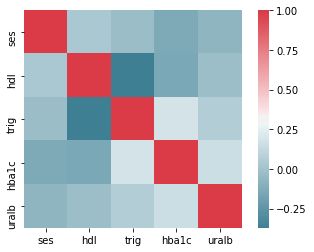

In [70]:
sns.heatmap(data_filtered_num.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True)

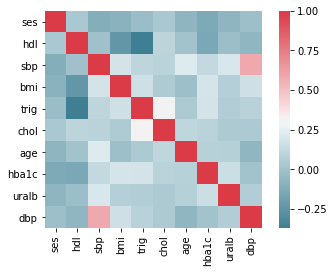

In [71]:
sns.heatmap(data[numerical_columns].corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True)

In [78]:
data_filtered_cat = pd.get_dummies(data[categorical_columns], drop_first=True)

In [79]:
data_filtered_cat.head()

,obese_no,obese_yes,hldhx_2.0,htnhx_hypertensive,htnhx_no,smokehx_yes,race_multiracial,race_non hispanic black,race_non hispanic white,sex_male,hf_yes,stroke_yes,mi_no,mi_yes
2,0,1,1,0,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,1,0,1,0,0,1,0
9,0,1,1,0,1,0,0,0,0,0,0,0,1,0
12,1,0,1,0,1,1,0,1,0,1,0,0,1,0
14,0,1,0,1,0,0,0,1,0,1,0,0,1,0


In [85]:
model_data = pd.concat((data_filtered_num, data_filtered_cat), axis=1)

In [86]:
model_data.head()

,ses,hdl,trig,hba1c,uralb,obese_no,obese_yes,hldhx_2.0,htnhx_hypertensive,htnhx_no,smokehx_yes,race_multiracial,race_non hispanic black,race_non hispanic white,sex_male,hf_yes,stroke_yes,mi_no,mi_yes
2,3.747,66.0,98.0,5.3,1.6,0,1,1,0,1,0,0,0,0,0,0,0,1,0
4,1.676,51.0,94.0,9.1,11.3,1,0,0,0,1,0,0,1,0,1,0,0,1,0
9,5.690,42.0,171.0,5.0,0.4,0,1,1,0,1,0,0,0,0,0,0,0,1,0
12,3.416,47.0,204.0,5.9,1.8,1,0,1,0,1,1,0,1,0,1,0,0,1,0
14,0.622,30.0,479.0,5.7,105.0,0,1,0,1,0,0,0,1,0,1,0,0,1,0


In [88]:
model_data.shape

(4541, 19)

In [89]:
data['mortstat'].shape

(4541,)

Split data into train and test

In [91]:
train_x, test_x, train_y, test_y = train_test_split(model_data, data['mortstat'], test_size = 0.3, random_state = 10)

In [93]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(3178, 19) (1363, 19) (3178,) (1363,)
